Let $\Sigma_t$ denote portfolio value under our managment
$$\Sigma_t = n_i(t) \cdot I_i(t),$$
where $n_i(t)$ -- position in the instrument $i$, $I_i(t)$ -- its present value

$$\dot\Sigma(t) = \dot n_i I_i + n_i \dot I_i$$

Hence we must implement Instruments' dynamics and portolio strategy to control $n_i$ 

In [1]:
import numpy as np
import pandas as pd
from lptools.utils import Adapter, Runner
from lptools.clients import Client
from lptools.instruments import UniPool, Bond, Portfolio, Position, Cash, Perpetual
from lptools.instruments import Holder, PerpetHedger
from copy import copy
import matplotlib.pyplot as plt
from lptools.solver import Solver

Skipping dotenv


In [2]:
zcurve = pd.read_csv('zcyc_rates.csv', index_col=0, parse_dates=True, infer_datetime_format=True, na_filter=False,)

adapter = Adapter(
        pool_id="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
        symbol="ETHUSDT",
        zcurve=zcurve,
        base_interval='1d'
)

# response = adapter(300)
#response.to_csv('saved_response.csv')

In [3]:
response = pd.read_csv('saved_response.csv', index_col=0, infer_datetime_format=True)
response.index = pd.to_datetime(response.index)
given_data = pd.read_csv('uniswap_usdcweth_0.05.csv', parse_dates=['date'], index_col=0, infer_datetime_format=True)
init_state = response.iloc[0]

In [4]:
response[response.index < '2021-12-03'].tail()

,fundingRate,Open,Volume,date,feesUSD,liquidity,sqrtPrice,token0Price,token1Price,tvlUSD,volumeUSD,mark,risk_free_rate
2021-11-26,0.000632,4528.20,2657050.069,1.637885e+09,717110.610623,2.178692e+19,1.246242e+33,4041.612472,0.000247,2.292489e+08,1.434221e+09,4525.911728,8.08
2021-11-27,0.000300,4040.66,1008009.177,1.637971e+09,312449.057898,2.165517e+19,1.237733e+33,4097.371402,0.000244,2.312423e+08,6.248981e+08,4041.870000,8.08
2021-11-28,0.000300,4095.33,1512818.390,1.638058e+09,437245.243253,2.791476e+19,1.208955e+33,4294.761309,0.000233,2.411140e+08,8.744905e+08,4095.855379,8.08
2021-11-29,0.000300,4297.01,1432921.208,1.638144e+09,386101.218819,3.182996e+19,1.188192e+33,4446.166582,0.000225,2.559034e+08,7.722024e+08,4296.600000,7.81
2021-11-30,0.000392,4445.09,2573876.207,1.638230e+09,661288.243740,1.938722e+19,1.163808e+33,4634.430105,0.000216,2.630019e+08,1.322576e+09,4444.687798,7.86


<AxesSubplot:xlabel='date'>

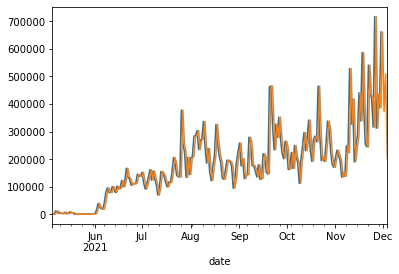

In [5]:
given_data.index = given_data.index.ceil('D')
response.feesUSD.plot()
given_data.feesUSD.plot()

In [6]:
solver = Solver(response)
results = solver.solve(t = 10,
             delta1=.1, q1=.95,
             delta2=.05, q2=.95,
             verbose=True, maxiter=20)

print(results)
pl, pu = map(lambda x: x*init_state.token0Price, results.x)

Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:


KeyboardInterrupt: 

In [5]:
pl, pu =  map(lambda x: x*init_state.token0Price, [.95, 1.21])

1. Hold

In [6]:
perpetual = Position(tag='perpet', instrument=Perpetual())
bond = Position(tag='bond', instrument=Bond(init_state))

positions = [perpetual, bond]
balancer = Holder(positions, initial_amounts=[1 / init_state.token0Price, -1])
portfolio_hold = Portfolio(balancer, positions=positions)

2. Passive pool

In [7]:

pool = Position(tag='pool', instrument=UniPool(init_state , price_lower=pl, price_upper=pu, fees=.005))
bond = Position(tag='bond', instrument=Bond(init_state))


positions = [pool, bond]
balancer = Holder(positions, initial_amounts=[1,-1])
portfolio_pool = Portfolio(balancer, positions=positions)

3. Hedging

In [8]:
pool = Position(tag='pool', instrument=UniPool(init_state , price_lower=pl, price_upper=pu, fees=.005))
bond = Position(tag='bond', instrument=Bond(init_state))
perpetual = Position(tag='perpet', instrument=Perpetual())

positions = [pool, perpetual, bond]

delta =  pool.instrument.L * (1 / init_state.token0Price**.5 - pu**(-.5))
balancer = PerpetHedger(
    positions,
    initial_amounts=[1, - delta, delta * init_state.token0Price - 1 ],
    rebalancing_interval= 1
)
portfolio_hedged = Portfolio(balancer, positions)

In [9]:
portfolios = [portfolio_hold, portfolio_pool, portfolio_hedged]

In [10]:
runner = Runner(response, portfolios)
runner.run()

In [11]:
runner.summary

,total_value,discounted_value,min_value
portfolio 0,-0.010003,-0.010001,-0.010003
portfolio 1,-0.020000,-0.019997,-0.020000
portfolio 2,-0.012238,-0.012235,-0.012238


In [12]:
runner.logs(2)

,pool_DV,pool_amount,pool_present_value,perpet_DV,perpet_amount,perpet_present_value,bond_DV,bond_amount,bond_present_value,payments,transaction_costs,cumulative_payments,in_cash,total_value
0,1.000020,0,0.0,3496.292879,0,0.0,1.000000,0,0.0,0.0,-1.218073e-02,0.000000,0.000000,0.000000
1,0.997176,0,0.0,3483.701459,0,0.0,1.000139,0,0.0,0.0,-2.281259e-06,-0.012179,-0.012181,-0.012181
2,1.061702,0,0.0,3884.370431,0,0.0,1.000279,0,0.0,0.0,-1.306046e-06,-0.012181,-0.012183,-0.012183
3,1.064054,0,0.0,3909.453752,0,0.0,1.000418,0,0.0,0.0,-7.501734e-08,-0.012183,-0.012184,-0.012184
4,1.068845,0,0.0,3968.366567,0,0.0,1.000558,0,0.0,0.0,-1.733866e-07,-0.012183,-0.012184,-0.012184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1.073395,0,0.0,4041.612472,0,0.0,1.028853,0,0.0,0.0,-5.165479e-07,-0.012234,-0.012237,-0.012237
205,1.075838,0,0.0,4097.371402,0,0.0,1.028997,0,0.0,0.0,-1.562686e-07,-0.012235,-0.012238,-0.012238
206,1.078215,0,0.0,4294.761309,0,0.0,1.029140,0,0.0,0.0,-3.602794e-07,-0.012235,-0.012238,-0.012238
207,1.078215,0,0.0,4446.166582,0,0.0,1.029284,0,0.0,0.0,0.000000e+00,-0.012235,-0.012238,-0.012238


In [13]:
runner.logs(1)

,pool_DV,pool_amount,pool_present_value,bond_DV,bond_amount,bond_present_value,payments,transaction_costs,cumulative_payments,in_cash,total_value
0,1.000020,0,0.0,1.000000,0,0.0,0.0,-0.02,0.000000,0.00,0.00
1,0.997176,0,0.0,1.000139,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
2,1.061702,0,0.0,1.000279,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
3,1.064054,0,0.0,1.000418,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
4,1.068845,0,0.0,1.000558,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
...,...,...,...,...,...,...,...,...,...,...,...
204,1.073395,0,0.0,1.028853,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
205,1.075838,0,0.0,1.028997,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
206,1.078215,0,0.0,1.029140,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02
207,1.078215,0,0.0,1.029284,0,0.0,0.0,0.00,-0.019997,-0.02,-0.02


In [14]:
res = runner.logs(2)

529.092303526571


<AxesSubplot:>

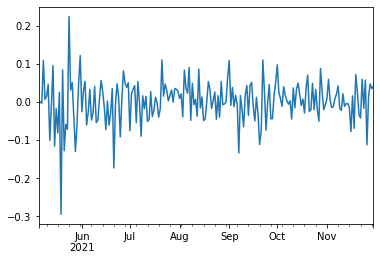

In [15]:
print(response.token0Price.diff().max())
np.log(response.token0Price).diff().plot()

In [16]:
response_second_half = response[response.index > '2021-08-01']
response_first_half = response[response.index < '2021-08-01']

In [17]:
second_half = Runner(response_second_half, portfolios)
first_half =  Runner(response_first_half, portfolios)

In [18]:
second_half.run()
second_half.summary

,total_value,discounted_value,min_value
portfolio 0,-0.010003,-0.010001,-0.010003
portfolio 1,-0.020000,-0.019996,-0.020000
portfolio 2,-0.012222,-0.012220,-0.012222


In [19]:
first_half.run()
first_half.summary

,total_value,discounted_value,min_value
portfolio 0,-0.010003,-0.010001,-0.010003
portfolio 1,-0.020000,-0.019997,-0.020000
portfolio 2,-0.012196,-0.012195,-0.012196
